tgb - 4/26/2019  
The goal is to build the PDF of precipitation for the +0K and +4K based on different neural networks.
  
We use the standard feed-forward configuration of the neural network:
***
[PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND, QRL, QRS, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN] as a function of:  
[QBP, QCBP, QIBP, TBP, VBP, Qdt_adiabatic, QCdt_adiabatic, QIdt_adiabatic, Tdt_adiabatic, Vdt_adiabatic, PS, SOLIN, SHFLX, LHFLX] 

# 1) Load modules and create training/validation data generators

In [1]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
import tensorflow as tf
import tensorflow.math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()
TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/'
PREFIX = '8col009_01_'
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM

/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM


tgb - 4/18/2019 - Used preprocessed data calculated in notebook 009 @ https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/009_Generalization_Climate_Change_8col.ipynb

In [2]:
scale_dict = load_pickle('./nn_config/scale_dicts/009_Wm2_scaling.pkl')
in_vars = load_pickle('./nn_config/scale_dicts/009_Wm2_in_vars.pkl')
out_vars = load_pickle('./nn_config/scale_dicts/009_Wm2_out_vars.pkl')
dP = load_pickle('./nn_config/scale_dicts/009_Wm2_dP.pkl')

# train_gen = DataGenerator(
#     data_fn = TRAINDIR+PREFIX+'train_shuffle.nc',
#     input_vars = in_vars,
#     output_vars = out_vars,
#     norm_fn = TRAINDIR+PREFIX+'norm.nc',
#     input_transform = ('mean', 'maxrs'),
#     output_transform = scale_dict,
#     batch_size=1024,
#     shuffle=True
# )
# valid_gen = DataGenerator(
#     data_fn = TRAINDIR+PREFIX+'valid.nc',
#     input_vars = in_vars,
#     output_vars = out_vars,
#     norm_fn = TRAINDIR+PREFIX+'norm.nc',
#     input_transform = ('mean', 'maxrs'),
#     output_transform = scale_dict,
#     batch_size=1024,
#     shuffle=False
# )

## 2) Develop precipitation PDF module of the Model Diagnostics object

## 2.1) Load architecture-constrained network

In [3]:
config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc'
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer}
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer}

%cd $TRAINDIR/HDF5_DATA
path = TRAINDIR+'HDF5_DATA/NNA.h5'
NN = load_model(path,custom_objects=dict_lay)
md = ModelDiagnostics(NN,config_fn,data_fn)

/data/Tom.Beucler/SPCAM_PHYS/HDF5_DATA
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


## 2.2 Build PDF of precip  
tgb - 4/26/2019 - Skeleton code of precip PDF  
1) Predict total dimensional precipitation on batch  
2) Accumulate in linearly spaced precipitation bins that go up to 350mm/d (based on Figure 2a of PNAS)  
3) Repeat for each batch to accumulate full PDF

In [94]:
# Nbin = 100
# Pmax = 350
# Pmin = 0
# PHIST = np.zeros(Nbin)

# P_CONV = 1e3*24*3600 # Conversion from m/s to mm/day

# for itime in range(25):
#     print(itime)
#     # 1) Predict total precipitation on batch (liquid equivalent in mm/day)
#     X, truth = md.valid_gen[itime]
#     pred = md.model.predict_on_batch(X)
#     PRECIP = (np.sum(pred[:,-4:],axis=1))*P_CONV/(L_V*RHO_L)

#     # 2) Calculate histogram
#     PRECIP_HIST,bin_edge = np.histogram(PRECIP,range=(Pmin,Pmax),bins=Nbin)

#     # 3) Accumulate histogram
#     PHIST += PRECIP_HIST

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [93]:
0.5*(bin_edge[:-1]+bin_edge[1:])

array([  1.75,   5.25,   8.75,  12.25,  15.75,  19.25,  22.75,  26.25,
        29.75,  33.25,  36.75,  40.25,  43.75,  47.25,  50.75,  54.25,
        57.75,  61.25,  64.75,  68.25,  71.75,  75.25,  78.75,  82.25,
        85.75,  89.25,  92.75,  96.25,  99.75, 103.25, 106.75, 110.25,
       113.75, 117.25, 120.75, 124.25, 127.75, 131.25, 134.75, 138.25,
       141.75, 145.25, 148.75, 152.25, 155.75, 159.25, 162.75, 166.25,
       169.75, 173.25, 176.75, 180.25, 183.75, 187.25, 190.75, 194.25,
       197.75, 201.25, 204.75, 208.25, 211.75, 215.25, 218.75, 222.25,
       225.75, 229.25, 232.75, 236.25, 239.75, 243.25, 246.75, 250.25,
       253.75, 257.25, 260.75, 264.25, 267.75, 271.25, 274.75, 278.25,
       281.75, 285.25, 288.75, 292.25, 295.75, 299.25, 302.75, 306.25,
       309.75, 313.25, 316.75, 320.25, 323.75, 327.25, 330.75, 334.25,
       337.75, 341.25, 344.75, 348.25], dtype=float32)

/home/t/Tom.Beucler/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


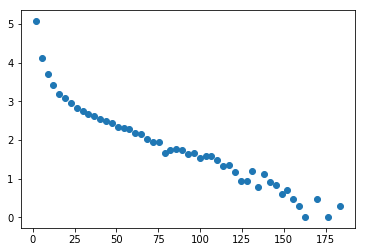

In [95]:
from matplotlib import pyplot as plt
import numpy as np

plt.scatter(0.5*(bin_edge[:-1]+bin_edge[1:]),np.log10(PHIST))